Apply Early stopping, Drop out , Normalization for a model


load the Iris dataset.
Preprocess the data (scale the features and encode the labels).
Build a neural network with dropout and batch normalization layers.
Add Early Stopping to monitor the validation loss and stop training when it stops improving.
Train the model and visualize the training history.

This program does the following:

StandardScaler normalizes the feature columns to have mean 0 and variance 1, which is important for neural network convergence.
OneHotEncoder converts the categorical target labels into a binary format suitable for multi-class classification.
EarlyStopping monitors the validation loss and stops the training process if the validation loss doesn't improve for 5 consecutive epochs, helping prevent overfitting.
Dropout randomly sets a fraction of the input units to 0 at each update during training time, which helps prevent overfitting.
BatchNormalization normalizes the activations of the previous layer at each batch, maintaining the mean activation close to 0 and the activation standard deviation close to 1.
After training, the graphs for loss and accuracy are generated to visualize how the model learns

Epoch 1, Val Loss: 0.4223, Accuracy: 0.8444
Epoch 2, Val Loss: 0.2552, Accuracy: 0.8667
Epoch 3, Val Loss: 0.1846, Accuracy: 0.9111
Epoch 4, Val Loss: 0.1492, Accuracy: 0.9333
Epoch 5, Val Loss: 0.1998, Accuracy: 0.8889
Epoch 6, Val Loss: 0.0738, Accuracy: 1.0000
Epoch 7, Val Loss: 0.0505, Accuracy: 1.0000
Epoch 8, Val Loss: 0.0417, Accuracy: 1.0000
Epoch 9, Val Loss: 0.0589, Accuracy: 1.0000
Epoch 10, Val Loss: 0.0719, Accuracy: 1.0000
Epoch 11, Val Loss: 0.0951, Accuracy: 0.9778
Epoch 12, Val Loss: 0.0935, Accuracy: 0.9778
Epoch 13, Val Loss: 0.0576, Accuracy: 1.0000
Epoch 14, Val Loss: 0.0379, Accuracy: 1.0000
Epoch 15, Val Loss: 0.0398, Accuracy: 0.9778
Epoch 16, Val Loss: 0.0403, Accuracy: 0.9778
Epoch 17, Val Loss: 0.0256, Accuracy: 1.0000
Epoch 18, Val Loss: 0.0350, Accuracy: 1.0000
Epoch 19, Val Loss: 0.0371, Accuracy: 1.0000
Epoch 20, Val Loss: 0.0371, Accuracy: 1.0000
Epoch 21, Val Loss: 0.0547, Accuracy: 0.9778
Epoch 22, Val Loss: 0.0338, Accuracy: 1.0000
Epoch 23, Val Loss:

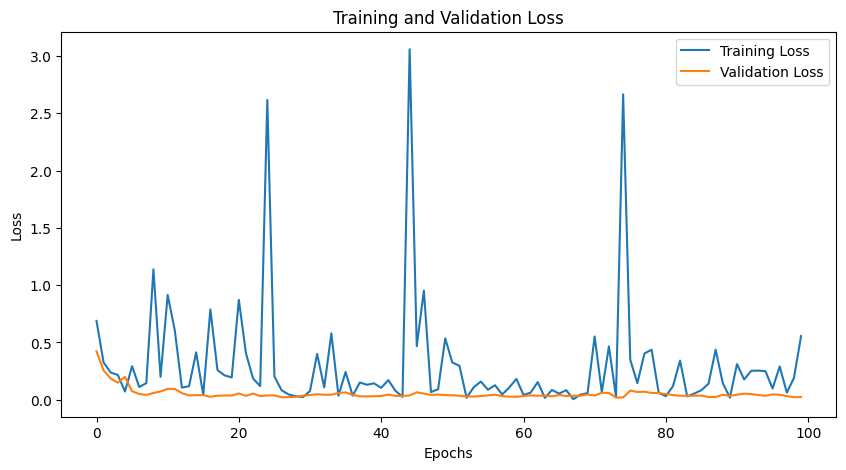

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encoding the labels
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(y)
y_encoded = y_encoded.astype(np.float32)

# Convert numpy arrays to PyTorch tensors
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
y_encoded = torch.tensor(y_encoded, dtype=torch.float32)

# Creating a dataset and dataloader
dataset = TensorDataset(X_scaled, y_encoded)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Defining the neural network with dropout and batch normalization
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = IrisNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# Training the model
def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopper, num_epochs=100):
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_loss, total, correct = 0, 0, 0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, torch.max(labels, 1)[1]).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == torch.max(labels, 1)[1]).sum().item()

            val_loss /= len(test_loader)
            accuracy = correct / total
            train_losses.append(loss.item())
            test_losses.append(val_loss)

            print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

            if early_stopper(val_loss):
                print("Early stopping")
                break

    return train_losses, test_losses

train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopper)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
